In [5]:
from keras.utils import image_dataset_from_directory
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import random
import keras 
import tensorflow as tf
from keras import layers
import PIL
import cv2
import os

2022-12-15 19:25:40.530235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 19:25:40.754511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 19:25:40.754565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 19:25:40.800519: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 19:25:42.572085: W tensorflow/stream_executor/platform/de

# Reading and preparing the dataset

In [6]:
encoding_dim=32
batch_size = 32
img_height = 256
img_width = 256
channels=3
img_shape=(img_height,img_width,channels)

300 40 3


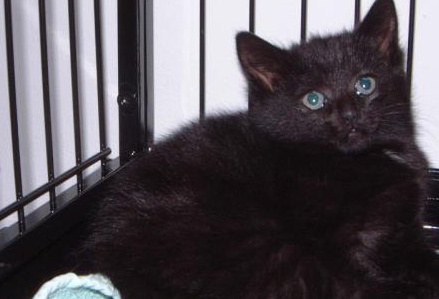

In [7]:
train='./Cats/train/'
test='./Cats/test/'
custom_images='./custom/'
test_path=pathlib.Path(test)
train_path=pathlib.Path(train)
custom_path=pathlib.Path(custom_images)
custom_imgs=len(list(custom_path.glob('**/*.jpg')))
image_train = len(list(train_path.glob('*/*.jpg')))
image_test = len(list(test_path.glob('*/*.jpg')))
print(image_train,image_test,custom_imgs)
# list dirs of images to preprocess on them
cats_train = list(train_path.glob('*/*'))
cats_test = list(test_path.glob('*/*'))
imgs_custom= list(custom_path.glob('**/*.jpg'))
PIL.Image.open(str(cats_train[0]))

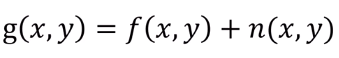
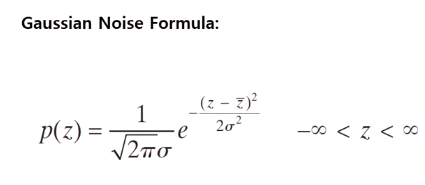

In [8]:
def prepare_data(list_of_img_dirs,img_shape):
    mean=0
    variance=0.01
    sigma=np.sqrt(variance)
    n=np.random.normal(loc=mean,scale=sigma,size=img_shape)
    plt.axis(False)
    plt.imshow(n,cmap='gray')    
    imgs_array_g=[]
    imgs_array=[]
    
    for img_dir in list_of_img_dirs:
        img = cv2.imread(str(img_dir))
        im=cv2.resize(img,img_shape[:2])
        im=im/255.0
        imgs_array.append(im)
        g=im+n
        imgs_array_g.append(g)
    return np.array(imgs_array),np.array(imgs_array_g)

def plot_real_decoded(real_imgs,decoded_imgs,n=10):
    # n=10
    plt.figure(figsize=(15,15))
    for i in range(1,n+1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(real_imgs[i].reshape(256, 256,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(decoded_imgs[i].reshape(256, 256,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


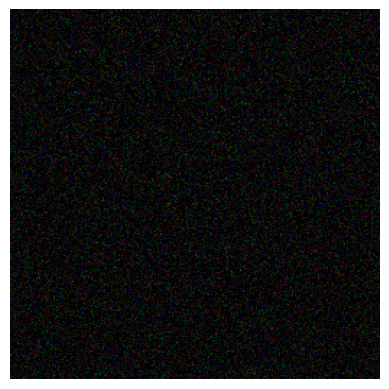

In [19]:
imgs_train,imgs_train_g=prepare_data(cats_train,img_shape)
imgs_test,imgs_test_g=prepare_data(cats_test,img_shape)
imgs_custom,imgs_custom_g=prepare_data(imgs_custom,img_shape)

In [20]:
print('images for training shape',imgs_train.shape)
print('images for testing shape',imgs_test.shape)
print('images for custom shape',imgs_custom.shape)

images for training shape (300, 256, 256, 3)
images for testing shape (40, 256, 256, 3)
images for custom shape (3, 256, 256, 3)


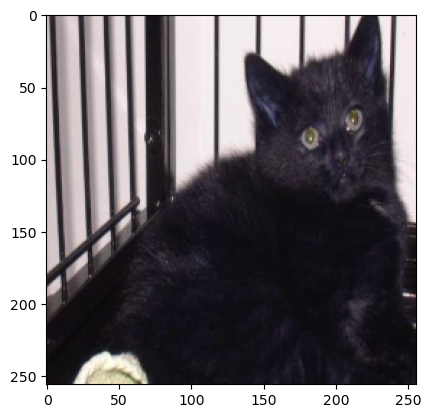

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


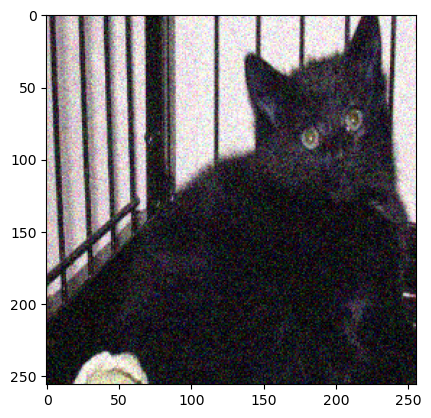

In [21]:
plt.imshow(imgs_train[0])
plt.show()
plt.imshow(imgs_train_g[0])
plt.show()

# Autoencoders Archs

```
Bulid First autoencoder "16x16x1"
```

In [13]:
input_img_1 = keras.Input(shape=img_shape)
x_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_1)
#256x256x16
x_1 = layers.MaxPooling2D((2, 2), padding='same')(x_1)
#128x128x16
x_1= layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x_1)
#128x128x8
x_1= layers.MaxPooling2D((2, 2), padding='same')(x_1)
#64x64x8
x_1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x_1)
#64x64x1
encoded_1 = layers.MaxPooling2D((2, 2), padding='same')(x_1)
#32x32x1
x_1 = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x_1)
#32x32x1
encoded_1 = layers.MaxPooling2D((2, 2), padding='same')(x_1)
#16x16x1

x_1 = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(encoded_1)
# 32x32x8
x_1 = layers.UpSampling2D((2, 2))(x_1)
#64x64x8
x_1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x_1)
#64x64x8
x_1 = layers.UpSampling2D((2, 2))(x_1)
#128*128*8
x_1 = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x_1)
# 128*128*16
x_1 = layers.UpSampling2D((2, 2))(x_1)
# 256*256*15
x_1 = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x_1)
# 128*128*16
decoded_1 = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_1)
# 256*256*3

In [25]:
autoencoder_1 = keras.Model(input_img_1, decoded_1)
autoencoder_1.compile(optimizer='adam', loss='MAE')
autoencoder_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 8)         1160

In [ ]:
autoencoder_1.fit(imgs_train_g, imgs_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                )

In [27]:
autoencoder_1.save('autoencoder2_16.h5')

In [28]:
from keras.models import load_model
trained_autoencoder_1 = load_model('autoencoder2_16.h5')

In [ ]:

# trained_autoencoder_1.fit(imgs_train_g, imgs_train,
#                 epochs=300,
#                 batch_size=16,
#                 shuffle=True,
#                 )

Epoch 1/300
19/19 [==============================] - 12s 607ms/step - loss: 0.0597
Epoch 2/300
19/19 [==============================] - 15s 711ms/step - loss: 0.0596
Epoch 3/300
19/19 [==============================] - 12s 607ms/step - loss: 0.0594
Epoch 4/300
19/19 [==============================] - 12s 610ms/step - loss: 0.0591
Epoch 5/300
19/19 [==============================] - 12s 611ms/step - loss: 0.0591
Epoch 6/300
19/19 [==============================] - 11s 603ms/step - loss: 0.0597
Epoch 7/300
19/19 [==============================] - 11s 602ms/step - loss: 0.0589
Epoch 8/300
19/19 [==============================] - 12s 617ms/step - loss: 0.0592
Epoch 9/300
19/19 [==============================] - 12s 613ms/step - loss: 0.0590
Epoch 10/300
19/19 [==============================] - 12s 607ms/step - loss: 0.0591
Epoch 11/300
19/19 [==============================] - 11s 601ms/step - loss: 0.0594
Epoch 12/300
19/19 [==============================] - 12s 613ms/step - loss: 0.0594
E

In [ ]:
trained_autoencoder_1.save('autoencoder2_16.h5')

In [29]:
decoded_imgs_1 = trained_autoencoder_1.predict(imgs_test_g)
decoded_custom_imgs_1=trained_autoencoder_1.predict(imgs_custom_g)

1/1 [==============================] - 0s 83ms/step


In [ ]:
plot_real_decoded(imgs_test,decoded_imgs_1,n=2)

In [ ]:
plot_real_decoded(imgs_custom,decoded_custom_imgs_1,n=2)

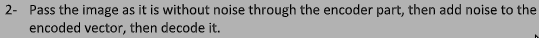

## Split the encoder and decoder part


In [ ]:
#Encoder
encoder1 = keras.Model(input_img_1, encoded_1)
#pass origin images to encoder part  without the noise
encoded_vectors_1=encoder1.predict(imgs_test)
custom_encoded_imgs = encoder.predict(imgs_test)
###Decoder
encoder_vector_shape=encoded_vectors_1.shape[1:]

input_img_d = keras.Input(shape=encoder_vector_shape)
x_d = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(input_img)
# 32x32x8
x_d = layers.UpSampling2D((2, 2))(x_d)
#64x64x8
x_d = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x_d)
#64x64x8
x_d = layers.UpSampling2D((2, 2))(x_d)
#128*128*8
x_d = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x_d)
# 128*128*16
x_d = layers.UpSampling2D((2, 2))(x_d)
# 256*256*16
decoded_d = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_d)
decoder1=keras.Model(input_img_d, decoded_d)
k=0
for i in range(7,14):
    decoder1.weights[k].assign(trained_autoencoder_1.weights[i])

In [ ]:
def add_noise(encoded_imgs):
    img_size=encoded_imgs.shape[1:]
    mean=0
    variance=0.01
    sigma=np.sqrt(variance)
    n=np.random.normal(loc=mean,scale=sigma,size=img_size)
    plt.axis(False)
    plt.imshow(n,cmap='gray')
    plt.title("Noise Shape")
    encoded_imgs_g=[]
    for encoded_img in encoded_imgs:   
        img=encoded_img/encoded_img.max()
        g=img+n
        encoded_imgs_g.append(g)
    return np.array(encoded_imgs_g)

In [ ]:
#Add Noise to the encoded vector
encoded_vectors_1_g=add_noise(encoded_vectors_1)
custom_encoded_imgs_g=add_noise(custom_encoded_imgs)
print(encoded_vectors_1_g.shape)
print(custom_encoded_imgs_g.shape)

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
print("Encoded Images")
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_vectors_1[i,:,:,0].reshape((32, 32)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
print("Encoded Images + Noise")
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)    
    plt.imshow(encoded_vectors_1_g[i,:,:,0].reshape((32, 32)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_imgs_1_d = decoder1.predict(encoded_vectors_1_g)
decoded_custom_1_d = decoder1.predict(custom_encoded_imgs_g)
decoded_imgs_1_d.shape

In [ ]:
plot_real_decoded(imgs_test,decoded_imgs_1_d,n=5)

## custom Dataset

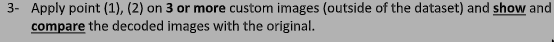

In [ ]:

plot_real_decoded(imgs_custom,decoded_custom_1,n=2)

In [104]:
input_img_ = keras.Input(shape=img_shape)

x_ = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_)
#256x256x32
x_ = layers.MaxPooling2D((2, 2), padding='same')(x_)
#128x128x32
x_ = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x_)
#128x128x16
x_ = layers.MaxPooling2D((2, 2), padding='same')(x_)
#64x64x16
x_ = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x_)
#64x64x8
x_ = layers.MaxPooling2D((2, 2), padding='same')(x_)
#32x32x8
x_ = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x_)
#32x32x1
encoded_ = layers.MaxPooling2D((2, 2), padding='same')(x_)
#16x16x1

x_ = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(encoded_)
#16x16x1
x_ = layers.UpSampling2D((2, 2))(x_)
#32x32x1
x_ = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x_)
#32x32x8
x_ = layers.UpSampling2D((2, 2))(x_)
#64x64x8
x_ = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x_)
#64x64x16
x_ = layers.UpSampling2D((2, 2))(x_)
# 128x128x16
x_ = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_)
# 128x128x32
# 256*256*1
decoded_ = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_)
# 256*256*3
autoencoder2= keras.Model(input_img_, decoded_)
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_57 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 64, 64, 8)         1160